# Testing the Straight Line Model

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.rcParams['savefig.dpi'] = 100

In [2]:
from straightline_utils import *

## The Data

* Let's generate a simple Cepheids-like dataset: observations of $y$ with reported uncertainties $\sigma_y$, at given $x$ values.


* Yours will look different to mine, as your random seed will be different. That's good - we can do some (completely unrealistic) comparisons over datasets.

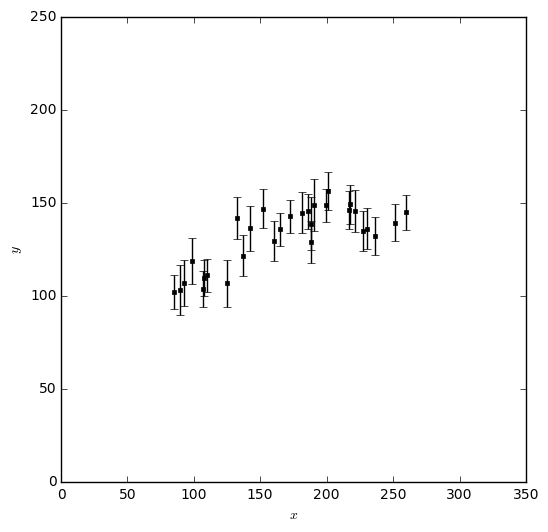

In [3]:
(x,y,sigmay) = generate_data()

plot_yerr(x, y, sigmay)

## Characterizing the posterior PDF

* Like we did in Session 2, we can evaluate the posterior PDF for the straight line model slope $m$ and intercept $b$ on a grid.


* Let's also take some samples, with a simple Metropolis routine.

In [4]:
def straight_line_log_likelihood(theta, x, y, sigmay):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''
    m,b = theta
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))


In [5]:
def straight_line_log_prior(theta, theta_limits):
    m, b = theta
    mlimits, blimits = theta_limits
    
    # Uniform in m:
    if (m < mlimits[0]) | (m > mlimits[1]):
        log_m_prior = -np.inf
    else:
        log_m_prior = np.log(1.0/(mlimits[1] - mlimits[0]))
    # Uniform in b:
    if (b < blimits[0]) | (b > blimits[1]):
        log_b_prior = -np.inf
    else:
        log_b_prior = np.log(1.0/(blimits[1] - blimits[0]))
        
    return log_m_prior + log_b_prior


def straight_line_log_posterior(theta, x, y, sigmay, theta_limits):
    return (straight_line_log_likelihood(theta, x, y, sigmay) +
            straight_line_log_prior(theta, theta_limits))

Grid maximum posterior values (m,b) = 0.26 88.0


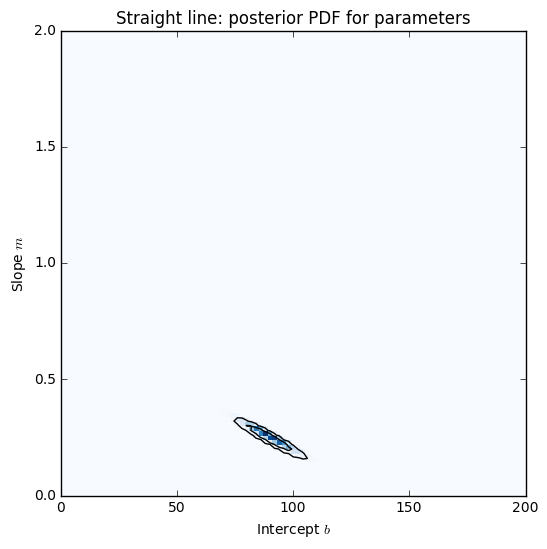

In [6]:
# Evaluate log P(m,b | x,y,sigmay) on a grid.

# Define uniform prior limits, enforcing positivity in both parameters:
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]
theta_limits = (mlimits, blimits)

# Set up grid:
mgrid = np.linspace(mlimits[0], mlimits[1], 101)
bgrid = np.linspace(blimits[0], blimits[1], 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))

# Evaluate log posterior PDF:
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        theta = (m,b)
        log_posterior[im,ib] = straight_line_log_posterior(theta, x, y, sigmay, theta_limits)

        
# Convert to probability density and plot, taking care with very small values:

posterior = np.exp(log_posterior - log_posterior.max())

plt.imshow(posterior, extent=[blimits[0],blimits[1],mlimits[0],mlimits[1]],cmap='Blues',
           interpolation='none', origin='lower', aspect=(blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print('Grid maximum posterior values (m,b) =', mgrid[i], bgrid[j])

plt.title('Straight line: posterior PDF for parameters');
plot_mb_setup(*theta_limits);

* And now to draw some samples:

In [7]:
def metropolis(log_posterior, theta, theta_limits, stepsize, nsteps=10000):
    '''
    log_posterior: function of theta 
    theta_limits:  uniform prior ranges
    stepsize:      scalar or vector proposal distribution width
    nsteps:        desired number of samples
    '''
    
    log_prob = log_posterior(theta, x, y, sigmay, theta_limits)
    
    # Store Markov chain as an array of samples:
    chain = np.empty((nsteps, len(theta)))
    log_probs = np.empty(nsteps)
    
    # Count our accepted proposals:
    naccept = 0
    
    for i in range(nsteps):
        
        theta_new = theta + stepsize * np.random.randn(len(theta))
        log_prob_new = log_posterior(theta_new, x, y, sigmay, theta_limits)

        if np.log(np.random.rand()) < (log_prob_new - log_prob):
            # accept, and move to the proposed position:
            theta = theta_new
            log_prob = log_prob_new
            naccept += 1
            
        else:
            # reject, and store the same sample as before:
            pass
        
        chain[i] = theta
        log_probs[i] = log_prob
        
    acceptance_rate = naccept/float(nsteps) 
    
    return chain,log_probs,acceptance_rate

In [8]:
# Initialize m, b at the center of prior:
m = 0.5*(mlimits[0]+mlimits[1])
b = 0.5*(blimits[0]+blimits[1])
theta = np.array([m,b])

# Step sizes, 2% or 5% of the prior
mstep = 0.02*(mlimits[1]-mlimits[0])
bstep = 0.05*(blimits[1]-blimits[0])
stepsize = np.array([mstep,bstep])        
    
# How many steps?
nsteps = 10000
   
print('Running Metropolis Sampler for', nsteps, 'steps...')

chain, log_probs, acceptance_rate = metropolis(
    straight_line_log_posterior, theta, theta_limits, stepsize, nsteps=nsteps
)

print('Acceptance fraction:', acceptance_rate)

Running Metropolis Sampler for 10000 steps...
Acceptance fraction: 0.1667


(0.0, 200.0)

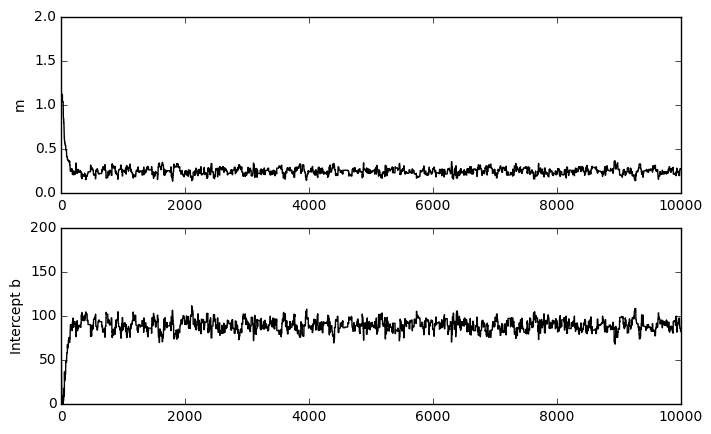

In [9]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for m,b in chain]
bb = [b for m,b in chain]

# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.ylabel('Intercept b')
plt.ylim(blimits)

* Looks reasonable: a short burn-in period, followed by reasonably well-mixed samples.


* Now let's look at the samples in parameter space, overlaid on our gridded posterior.

In [10]:
!pip install --upgrade --no-deps corner

Requirement already up-to-date: corner in /Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages


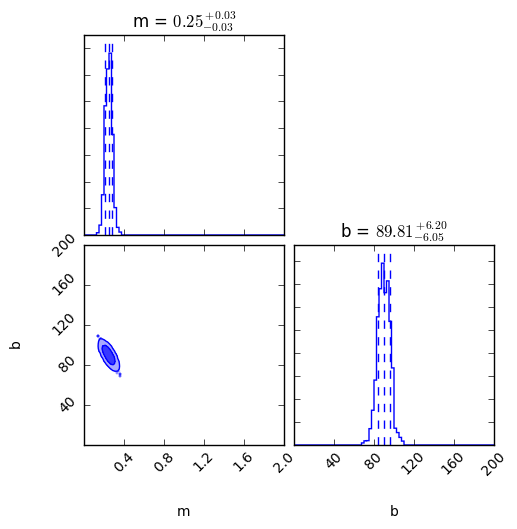

In [11]:
import corner
corner.corner(chain[5000:], labels=['m','b'], range=[mlimits,blimits],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=80, smooth=1.0);

* It looks like we made a nice, precise measurement! 


* We made a lot of assumptions though - so we now need to test them. Our next step is to check the model for accuracy.

# Model Checking

* How do we know if our model is any good? One property that "good" models have is *accuracy.*


* Accurate models generate data that is *like* the observed data. What does this mean? First we have to define what similarity is, in this context. 


* *Visual impression* is one very important way, that's usually best done first.


* *Test statistics* that capture relevant features of the data are another. It's good to explore the posterior predictive distribution for these statistics, as a way of propagating our uncertainty in the model parameters into our predictions.

## Visual Model Checking

* Plot realizations of the model in data space.

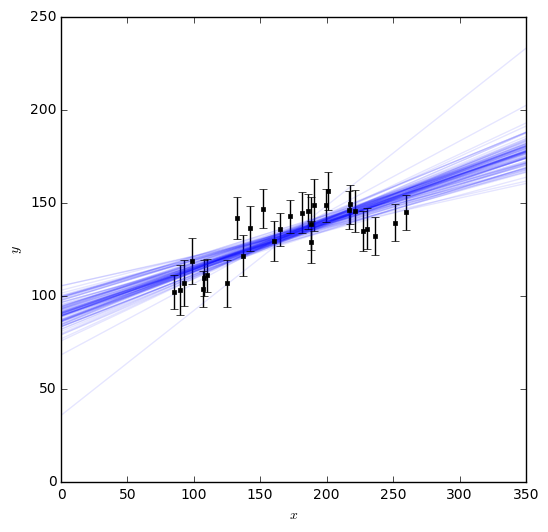

In [12]:
# Generate a straight line model for each parameter combination, and plot:
X = np.linspace(xlimits[0],xlimits[1],50)
for i in (np.random.rand(100)*len(chain)).astype(int):
    m,b = chain[i]
    plt.plot(X, b+X*m, 'b-', alpha=0.1)

# Overlay the data, for comparison:
plot_yerr(x, y, sigmay);

## Posterior Predictive Model Checking

* If our model is the true one, then *replica* data generated by it should look like the one dataset we have. This means that *summaries* of both the real dataset, $T(d)$, and the replica datasets, $T(d^{\rm rep})$, should be drawn from the same distribution. 


* If the real dataset was not generated with our model, then its summary may be an outlier from the distribution of summaries of replica datasets.


* We can account for our uncertainty in the parameters $\theta$ by marginalizing them out, which can be easily done by just making the histogram of $T(d^{\rm rep}(\theta))$ from our posterior samples, after drawing one replica dataset $d^{\rm rep}$ from the model sampling distribution ${\rm Pr}(d^{\rm rep}\,|\,\theta)$ for each one.


* Then, we can ask: what is the posterior probability for the summary $T$ to be greater than the observed summary $T(d)$? If this is very small or very large, we should be suspicious of our model - because it is not predicting the data very accurately.

${\rm Pr}(T(d^{\rm rep})>T(d)\,|\,d) = \int I(T(d^{\rm rep})>T(d))\,{\rm Pr}(d^{\rm rep}\,|\,\theta)\,{\rm Pr}(\theta\,|\,d)\;d\theta\,dd^{\rm rep}$

* Here $I$ is the "indicator function" - 1 or 0 according to the condition. 

Pr(T>T(d)|d) =  50.15 %


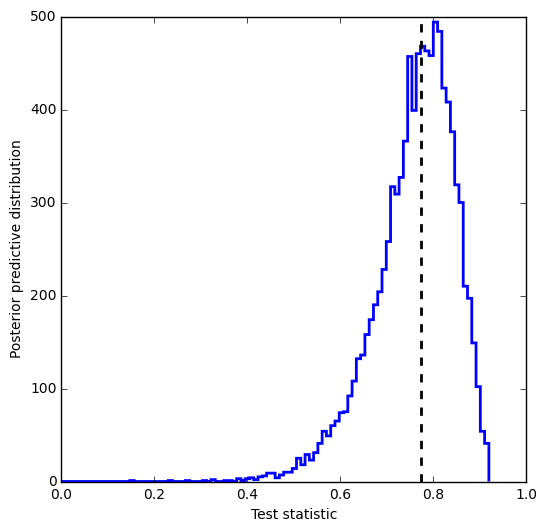

In [13]:
# Test statistics: functions of the data, not the parameters.

# 1) Weighted mean y:
# def test_statistic(x,y,sigmay):
#    return np.sum(y/sigmay**2.0)/np.sum(1.0/sigmay**2.0)

# 2) Variance of y:
# def test_statistic(x,y,sigmay):
#    return np.var(y)

# 3) Pearson r correlation coefficient:
import scipy.stats
def test_statistic(x,y,dummy):
    '''
    Pearson r correlation coefficient:
    r12 = \sum [(xi - xbar)*(yi - ybar)] / [\sum (xi - xbar)^2 * \sum (yi - ybar)^2]^1/2
    '''
    r12 = np.sum((x - np.mean(x))*(y - np.mean(y))) / \
          np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((y - np.mean(y))**2))
    return r12


# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T:
T = np.zeros(len(chain))
for k,(m,b) in enumerate(chain):
    yrep = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = test_statistic(x,yrep,sigmay)
    
# Compare with the test statistic of the data, on a plot:   
Td = test_statistic(x, y, sigmay)

plt.hist(T, 100, histtype='step', color='blue', lw=2, range=(0.0,np.percentile(T,99.0)))
plt.axvline(Td, color='black', linestyle='--', lw=2)
plt.xlabel('Test statistic')
plt.ylabel('Posterior predictive distribution')

# What is Pr(T>T(d)|d)?

greater = (T > Td)
P = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d) = ",P,"%")

* If our model is true (and we're just uncertain about its parameters, given the data), we can compute the probability of getting a $T$ less than that observed.


* Note that we did not have to look up any particular standard distribution - we can simply compute the posterior predictive distribution given our generative model.


* This test statistic lacks power: better choices might put more acute stress on the model to perform, by focusing on the places where the model predictions are suspect.

* Test statistics $T(d,\theta)$ that are functions of both the data and the parameters are known as *discrepancy measures.* 


* Similar in spirit to the above, we can compute the posterior probability of getting $T(d^{\rm rep},\theta) > T(d,\theta)$:

${\rm Pr}(T(d^{\rm rep},\theta)>T(d,\theta)\,|\,d) = \int I(T(d^{\rm rep},\theta)>T(d,\theta))\,{\rm Pr}(d^{\rm rep}\,|\,\theta)\,{\rm Pr}(\theta\,|\,d)\;d\theta\,dd^{\rm rep}$

(0.0, 1.8255929345143136)

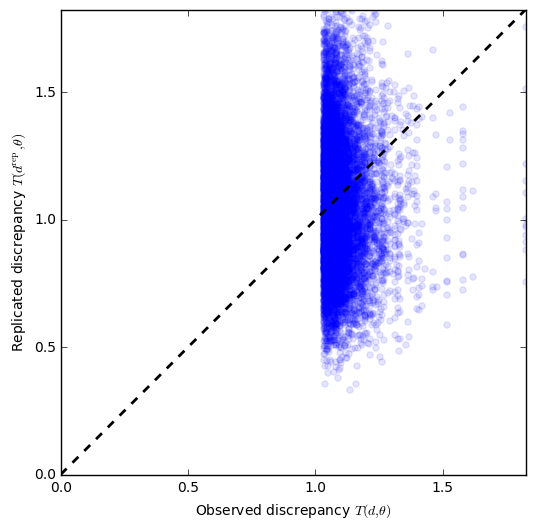

In [14]:
# Discrepancy: functions of the data AND parameters.

# 1) Reduced chisq for the model:
def discrepancy(x,y,sigmay,b,m):
   return np.sum((y - m*x - b)**2.0/sigmay**2.0)/(len(y)-2)

# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T, 
# AND ALSO its Td (which now depends on the parameters, too):
T = np.zeros(len(chain))
Td = np.zeros(len(chain))
for k,(m,b) in enumerate(chain):
    yrep = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = discrepancy(x,yrep,sigmay,b,m)
    Td[k] = discrepancy(x,y,sigmay,b,m)
    
# Compare T with Td, on a scatter plot - how often is T>Td?   

plt.scatter(Td, T, color='blue',alpha=0.1)
plt.plot([0.0, 100.0], [0.0, 100.], color='k', linestyle='--', linewidth=2)
plt.xlabel('Observed discrepancy $T(d,\\theta)$')
plt.ylabel('Replicated discrepancy $T(d^{\\rm rep},\\theta)$')
plt.ylim([0.0,np.percentile(Td,99.0)])
plt.xlim([0.0,np.percentile(Td,99.0)])


Pr(T>T(d)|d) =  42.29 %


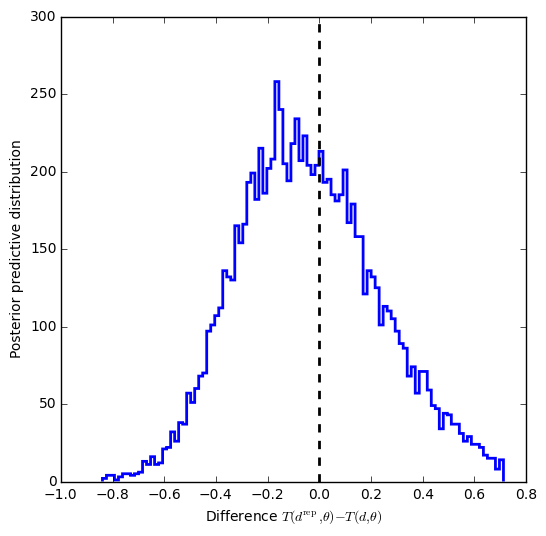

In [15]:
# Histogram of differences:

diff = T-Td
plt.hist(diff, 100, histtype='step', color='blue', lw=2, range=(np.percentile(diff,1.0),np.percentile(diff,99.0)))
plt.axvline(0.0, color='black', linestyle='--', lw=2)
plt.xlabel('Difference $T(d^{\\rm rep},\\theta) - T(d,\\theta)$')
plt.ylabel('Posterior predictive distribution')


# What is Pr(T>T(d)|d)?

greater = (T > Td)
Pline = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d) = ",Pline,"%")

* The conclusion drawn from the discrepancy is more interesting, in this case. All our $\theta = (m,b)$ samples are plausible, so replica datasets generated by them should also be plausible. The straight line defined by each $(m,b)$ should go through the real data points as readily (*on average*) as it does its replica dataset.


* Do our posterior predictive $p-$values suggest we need to improve our model? What about the visual check?

### Exercise:

* In some sense, the reduced chi-squared is actually not such an interesting test statistic, because it's very similar to the log likelihood! 

* Still more powerful discrepancy measures might stress-test *different* aspects of the model. Talk to your neighbor about where and how this model might be failing, and see if you can design a better discrepancy measure than reduced chi-squared.

# Model Expansion


* Maybe I see some curvature in the data - or maybe I have a new astrophysical idea for how this data was generated. Let's try adding an extra parameter to the model, to make a quadratic function: 

$y = m x + b + q x^2$


* The coefficient $q$ is probably pretty small (we were originally expecting to only have to use a straight line model for these data!), so I guess we can assign a fairly narrow prior, centered on zero.

In [16]:
def quadratic_log_likelihood(theta, x, y, sigmay):
    '''
    Returns the log-likelihood of drawing data values y at
    known values x given Gaussian measurement noise with standard
    deviation with known sigmay, where the "true" y values are
    y_t = m*x + b + q**2

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept
    q: quadratic term coefficient

    where theta = (m, b, q)

    Returns: scalar log likelihood
    '''
    m, b, q = theta
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b + q*x**2))**2 / sigmay**2))
    
    
def quadratic_log_prior(theta, theta_limits):
    m, b, q = theta
    mlimits, blimits, qpars = theta_limits
    
    # m and b:
    log_mb_prior = straight_line_log_prior(np.array([m,b]), np.array([mlimits, blimits]))
    # q:
    log_q_prior = np.log(1./(np.sqrt(2.*np.pi) * qpars[1])) - \
                  0.5 * (q - qpars[0])**2 / qpars[1]**2
    return log_mb_prior + log_q_prior
    
    
def quadratic_log_posterior(theta, x, y, sigmay, theta_limits):
    return (quadratic_log_likelihood(theta, x, y, sigmay) +
            quadratic_log_prior(theta, theta_limits))

In [27]:
# Define uniform prior limits, enforcing positivity in m and b:
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]
# Define Gaussian prior centered on zero for q:
qpars = [0.0,0.003]

# Initialize m, b at the center of prior:
m = 0.5*(mlimits[0]+mlimits[1])
b = 0.5*(blimits[0]+blimits[1])
q = qpars[0]

# Arrays to pass to the sampler:
qtheta = np.array([m,b,q])
qtheta_limits = (mlimits, blimits, qpars)

# Step sizes, small fractions of the prior width:
mstep = 0.02*(mlimits[1]-mlimits[0])
bstep = 0.04*(blimits[1]-blimits[0])
qstep = 0.04*qpars[1]
stepsize = np.array([mstep,bstep,qstep])        
    
# How many steps?
nsteps = 10000
   
print('Running Metropolis Sampler for', nsteps, 'steps...')

qchain, log_probs, acceptance_rate = metropolis(
    quadratic_log_posterior, qtheta, qtheta_limits, stepsize, nsteps=nsteps
)

print('Acceptance fraction:', acceptance_rate)

Running Metropolis Sampler for 10000 steps...
Acceptance fraction: 0.1636


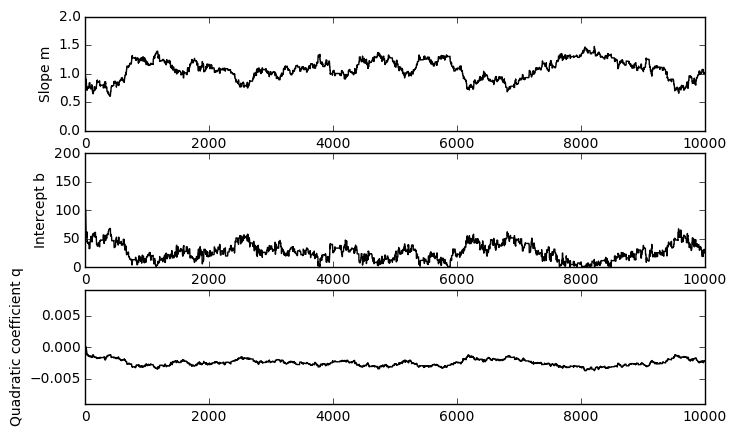

In [28]:
# Pull m, b and q arrays out of the Markov chain and plot them:
mm = [m for m,b,q in qchain]
bb = [b for m,b,q in qchain]
qq = [q for m,b,q in qchain]

# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('Slope m')
plt.subplot(3,1,2)
plt.plot(bb, 'k-')
plt.ylim(blimits)
plt.ylabel('Intercept b')
plt.subplot(3,1,3)
plt.plot(qq, 'k-')
plt.ylim([qpars[0]-3*qpars[1],qpars[0]+3*qpars[1]])
plt.ylabel('Quadratic coefficient q')

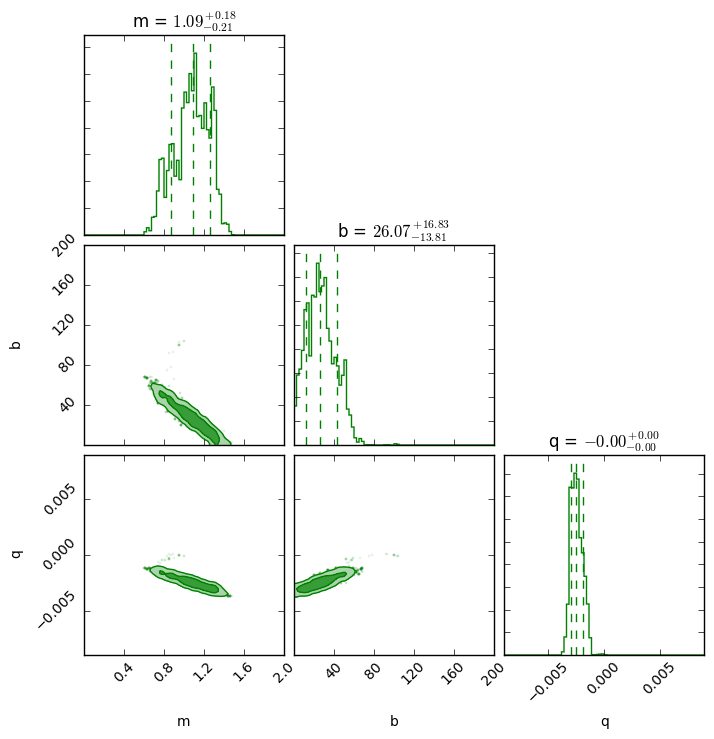

In [29]:
corner.corner(qchain, labels=['m','b','q'], range=[mlimits,blimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='green', bins=80, smooth=1.0);

* All parameters are again precisely constrained.


* The gradient and intercept $m$ and $b$ are significantly different from before, though...

## Checking the Quadratic Model

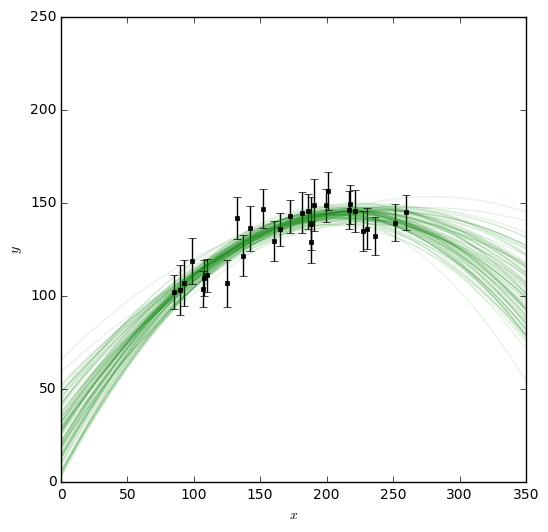

In [30]:
# Posterior visual check, in data space:
X = np.linspace(xlimits[0],xlimits[1],100)
for i in (np.random.rand(100)*len(chain)).astype(int):
    m,b,q = qchain[i]
    plt.plot(X, b + X*m + q*X**2, 'g-', alpha=0.1)
plot_yerr(x, y, sigmay)

Pr(T>T(d)|d,quadratic) =  94.49 %, cf. Pr(T>T(d)|d,straightline) =  42.29 %


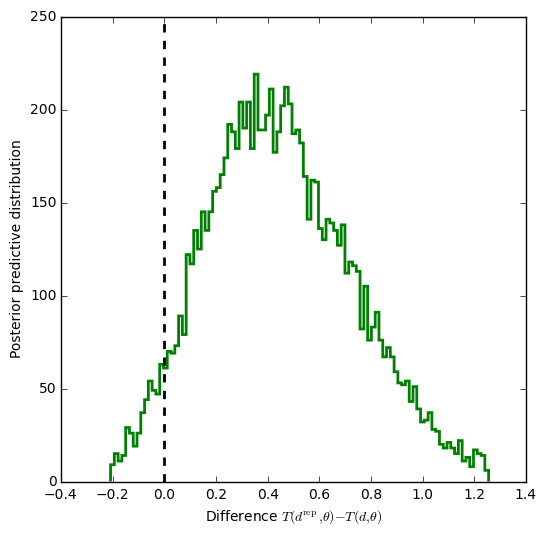

In [33]:
# Discrepancy: functions of the data AND parameters.

# 1) Reduced chisq for the model:
def discrepancy(x,y,sigmay,m,b,q):
   return np.sum((y - m*x - b - q*x**2)**2.0/sigmay**2.0)/(len(y)-3)


# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T, 
# AND ALSO its Td:
T = np.zeros(len(qchain))
Td = np.zeros(len(qchain))
for k,(m,b,q) in enumerate(qchain):
    yp = b + m*x + q*x**2 + sigmay*np.random.randn(len(x))
    T[k] = discrepancy(x,yp,sigmay,m,b,q)
    Td[k] = discrepancy(x,y,sigmay,m,b,q)

# Histogram of differences:
diff = T - Td
plt.hist(diff, 100, histtype='step', color='green', lw=2, range=(np.percentile(diff,1.0),np.percentile(diff,99.0)))
plt.axvline(0.0, color='black', linestyle='--', lw=2)
plt.xlabel('Difference $T(d^{\\rm rep},\\theta) - T(d,\\theta)$')
plt.ylabel('Posterior predictive distribution')

# What is Pr(T>T(d)|d)?
greater = (T > Td)
Pquad = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d,quadratic) = ",Pquad,"%, cf. Pr(T>T(d)|d,straightline) = ",Pline,"%")

* How do the two models compare? Which one matches the data better?


In [ ]:
# %load straightline_utils.py
# numpy: numerical library
import numpy as np
# avoid broken installs by forcing Agg backend...
#import matplotlib
#matplotlib.use('Agg')
# pylab: matplotlib's matlab-like interface
import pylab as plt

# The data we will fit, sometimes:
#  x, y, sigma_y
data1 = np.array([[201,592,61],[244,401,25],[47,583,38],[287,402,15],[203,495,21],
                  [58,173,15],[210,479,27],[202,504,14],[198,510,30],[158,416,16],
                  [165,393,14],[201,442,25],[157,317,52],[131,311,16],[166,400,34],
                  [160,337,31],[186,423,42],[125,334,26],[218,533,16],[146,344,22]]).astype(float)

# plotting limits
xlimits = [0,350]
ylimits = [0,250]
title_prefix = 'Straight line'
plot_format = '.png'

# uniform prior
# mlimits = [1.9, 2.6]
# blimits = [-20, 80]
# mlimits = [-2.0, 2.0]
# blimits = [-200, 200]
# mlo,mhi = mlimits
# blo,bhi = blimits
slimits = [0.001,100]
slo,shi = slimits

def pdf_contour_levels(p):
    sortp = np.sort(p.ravel())
    cump = sortp.cumsum()
    return [sortp[cump > cump.max() * f].min()
            for f in [0.32, 0.05]]

def plot_mcmc_results(chain,mlimits,blimits):
    # Pull m and b arrays out of the Markov chain.
    mm = [m for b,m in chain]
    bb = [b for b,m in chain]
    # Scatterplot of m,b posterior samples
    plt.clf()
    plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior))
    plt.plot(bb, mm, 'b.', alpha=0.1)
    plot_mb_setup(mlimits,blimits)
    plt.show()

    # Histograms
    import triangle
    triangle.corner(chain, labels=['b','m'], extents=[0.99]*2)
    plt.show()

    # Traces
    plt.clf()
    plt.subplot(2,1,1)
    plt.plot(mm, 'k-')
    plt.ylim(mlimits[0],mlimits[1])
    plt.ylabel('m')
    plt.subplot(2,1,2)
    plt.plot(bb, 'k-')
    plt.ylabel('b')
    plt.ylim(blimits[0],blimits[1])
    plt.show()


def plot_mb_setup(mlimits,blimits):
    plt.xlabel('Intercept $b$')
    plt.ylabel('Slope $m$')
    plt.axis([blimits[0],blimits[1], mlimits[0],mlimits[1]])

def get_data_no_outliers():
    # pull out the x, y, and sigma_y columns, which have been packed into the
    # "data1" matrix.  "data1" has shape (20,3).  ":" means "everything in
    # that dimension".  Some of the first 5 points are outliers so for this
    # part we only grab from index 5 on, with magic "5:"
    x = data1[5:,0]
    y = data1[5:,1]
    sigmay = data1[5:,2]
    return (x, y, sigmay)

def get_data_with_outliers():
    x = data1[:,0]
    y = data1[:,1]
    sigmay = data1[:,2]
    return x,y,sigmay

def generate_data():
    '''
    Generate a data set, with x and sigma_y as standard, but with
    y values given by

    y = a_0 + a_1 * x + a_2 * x**2 + a_3 * x**3 + noise

    '''
    # x = data1[5:,0]
    # sigmay = data1[5:,2]

    Ndata = 30

    xbar = 0.5*(xlimits[0] + xlimits[1])
    xstd = 0.15*(xlimits[1] - xlimits[0])

    x = xbar + xstd * np.random.randn(Ndata)

    meanerr = 0.025*(xlimits[1] - xlimits[0])

    sigmay = meanerr + 0.3 * meanerr * np.abs(np.random.randn(Ndata))

    a = np.array([37.2,0.93,-0.002,0.0])
    y = a[0] + a[1] * x + a[2] * x**2 + a[3] * x**3 + sigmay*np.random.randn(len(x))

    return x,y,sigmay

# Plot data with error bars, standard axis limits, etc.
def plot_yerr(x, y, sigmay):
    # plot data with error bars
    plt.errorbar(x, y, yerr=sigmay, fmt='.', ms=7, lw=1, color='k')
    # if you put '$' in you can make Latex labels
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    # plt.title(title_prefix)

# Plot a   y = mx + b  line.
def plot_line(m, b, **kwargs):
    x = np.array(xlimits)
    y = b + m*x
    p = plt.plot(x, y, 'k-', alpha=0.5, **kwargs)
    plt.xlim(*xlimits)
    plt.ylim(*ylimits)
    return p


-----

# Model Comparison with the Evidence

* In the posterior predictive check above we found it useful to consider the probability distribution of hypothetical replica datasets. 


* As well as this, we also have access to the quantity ${\rm Pr}(d\,|\,H)$, the evidence for the model $H$. [Let's take a look at its properties](../../notes/Evidence.ipynb). 

## Calculating the Evidence

* The FML is in general quite difficult to calculate, since it involves averaging the likelihood over the prior. MCMC gives us samples from the posterior - and these cannot, it turns out, be reprocessed so as to estimate the evidence stably.


* A number of sampling algorithms have been developed that *do* calculate the evidence, during the process of sampling. These include:

  * Nested Sampling (including MultiNest and DNest)
  * Parallel Tempering, Thermodynamic Integration
  * ...


* If we draw samples from the *prior*, we can then estimate the evidence via the usual sum over samples,

${\rm Pr}(d\,|\,H) \approx \frac{1}{N_s} \sum_k\;{\rm Pr}(d\,|\,\theta_s,H)$
  

> #### Simple Monte Carlo: 
> Consider the simplest possbile posterior inference, the mean of parameter $\theta$:
>  
> $\bar{\theta} = \int\,\theta\,{\rm Pr}(\theta\,|\,d,H)\,d\theta$
> 
> This is approximated by an average over posterior samples:
>
> $\bar{\theta} \approx \frac{1}{N_s}\,\sum_s\,\theta_s$
>
> Now replace the posterior PDF with Bayes' Theorem:
>
> $\bar{\theta} = \frac{1}{Z} \int\,\theta\,{\rm Pr}(d\,|\,\theta,H)\,{\rm Pr}(\theta\,|\,H)\,d\theta$
>
> and the posterior samples with prior samples:
> 
> $\bar{\theta} \approx \frac{1}{(Z N_s)}\,\sum_s\,\theta_s\,{\rm Pr}(d\,|\,\theta_s,H)$
>
> This is a *weighted mean* - if we don't want $Z$, we just define weights $w_s = {\rm Pr}(d\,|\,\theta_s,H)$ compute the approximate posterior mean as the likelihood-weighted prior mean:
> 
> $\bar{\theta} \approx \frac{\sum_s\,w_s\,\theta_s}{\sum_s\,w_s}$
>
> To compute Z, we multiply both sides by $Z$ and replace $\theta$ with 1:
>
> $Z \approx \frac{1}{N_s} \sum_s\,\,w_s$


* Simple Monte Carlo works well in certain low-dimensional situations, but in general it is very inefficient (at best). 


* Still, let's give it a try on our two models, and attempt to compute the evidence ratio 
  
$R = \frac{{\rm Pr}(d\,|\,{\rm quadratic})}{{\rm Pr}(d\,|\,{\rm straight line})}$

In [37]:
# Draw a large number of prior samples and calculate the log likelihood for each one:
N = 50000

# Set the priors:
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]
qpars = [0.0,0.003]

# Sample from the prior:
mm = np.random.uniform(mlimits[0],mlimits[1], size=N)
bb = np.random.uniform(blimits[0],blimits[1], size=N)
qq = qpars[0] + qpars[1]*np.random.randn(N)

# We'll store the posterior samples as a "chain" again
schain = []

log_likelihood_straight_line = np.zeros(N)
log_likelihood_quadratic = np.zeros(N)
for i in range(N):
    theta = np.array([mm[i], bb[i]])
    log_likelihood_straight_line[i] = straight_line_log_likelihood(theta, x, y, sigmay)
    qtheta = np.array([mm[i], bb[i], qq[i]])
    log_likelihood_quadratic[i] = quadratic_log_likelihood(qtheta, x, y, sigmay)    

    schain.append((mm[i],bb[i],qq[i]))

Now that we have the log likelihood for each sample, let's check that we did actually sample the posterior well. Here are the corner plots (note that for plotting, the weights don't need to be correctly normalized - and also that we do *not* want to plot the points as well as the contours, since the points are prior samples not posterior ones!):

In [38]:
# Unnormalized likelihoods for plotting:

unnormalized_likelihood_straight_line = np.exp(log_likelihood_straight_line - log_likelihood_straight_line.max())
unnormalized_likelihood_quadratic = np.exp(log_likelihood_quadratic - log_likelihood_quadratic.max())

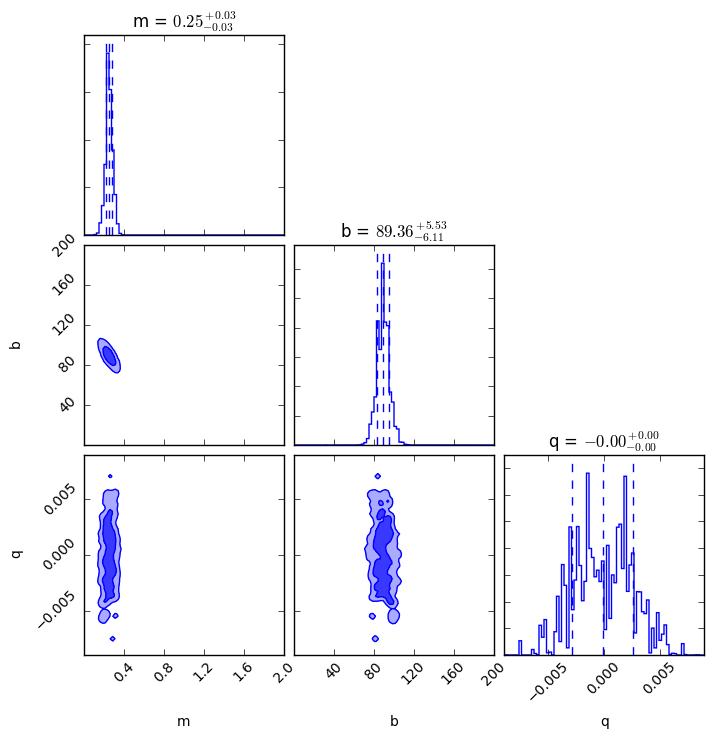

In [39]:
corner.corner(schain, labels=['m','b','q'], range=[mlimits,blimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                weights=unnormalized_likelihood_straight_line,
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], 
                color='blue', bins=80, smooth=1.0);

### Question:

* Why does $q$ appear in this plot? Does it affect the evidence calculation?

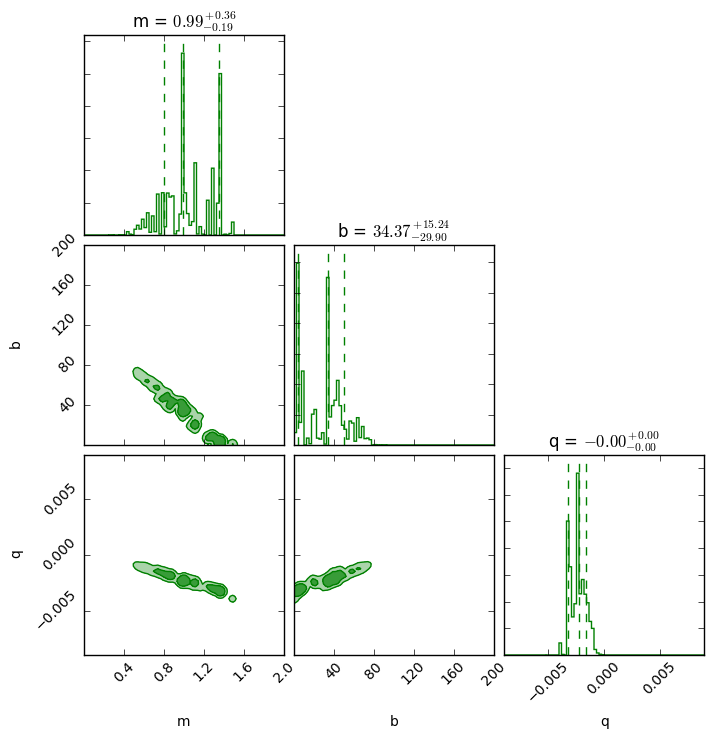

In [40]:
corner.corner(schain, labels=['m','b','q'], range=[mlimits,blimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                weights=unnormalized_likelihood_quadratic,
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=False, fill_contours=True, levels=[0.68, 0.95], 
                color='green', bins=80, smooth=1.0);

Now let's compute the evidence - we'll need a special function that stably calculates the average $x$ given an array of $\log x$...

In [41]:
def logaverage(x):
    mx = x.max()
    return np.log(np.sum(np.exp(x - mx))) + mx - np.log(len(x))

log_evidence_straight_line = logaverage(log_likelihood_straight_line)
log_evidence_quadratic = logaverage(log_likelihood_quadratic)

print('log Evidence for Straight Line Model:', log_evidence_straight_line)
print('log Evidence for Quadratic Model:', log_evidence_quadratic)

print('Evidence ratio in favour of the Quadratic Model:', np.int(np.exp(log_evidence_quadratic - log_evidence_straight_line)),"to 1")

log Evidence for Straight Line Model: -119.852284119
log Evidence for Quadratic Model: -115.417268996
Evidence ratio in favour of the Quadratic Model: 84 to 1


### Exercise:

Play around with the Simple Monte Carlo evidence estimate, and see if you can break it. 

* Try running it a few times, with the same `N`: how precise are these evidence estimates from 50000 samples?

* We said we believed *a priori* that $q$ should be small, and set the prior width accordingly. What would happen if we started to doubt ourselves, and re-assigned a broader prior? Try running with some larger values for the Gaussian prior width $q[1]$, and note what happens to the Bayes Factor.

## Notes

* The Bayesian evidence is *qualitatively different* from other model assessments. While they focus primarily on *prediction accuracy,* the evidence is the way in which information from the prior PDF propagates through into our posterior beliefs about the model as a whole.


* There are no mathematical limitations to its use[[*citation needed*]](), in contrast to various other hypothesis tests that are only valid under certain assumptions (such as the models being nested). Any two models can be compared and the odds ratio computed.


* Jeffreys provided a scale to aid the interpretation of Bayes Factors:

| **R**  | **Strength of evidence**|
|--------|:------------------------|
|  < 1   | Negative |
|  1-3   | Barely worth mentioning |
|  3-10  | Substantial |
| 10-30  | Strong |
| 30-100 | Very strong |
|   >100 | Decisive

Note that evidence ratios can be interpreted in very similar ways to *odds* at the Bookmakers.

### Information Criteria

A number of "information criteria" exist in the statistical literature, as *easier-to-calculate alternatives* to the Bayesian Evidence. They all have the form:

$XIC(H) = -2\log \hat{L} + C$

* Here, the $\hat{L}$ term captures the goodness of fit of the model $H$, while the constant $C$ increases with model complexity. Models with *low* $XIC$ are preferred - for having high goodness of fit at low model complexity. Popular choices are the Bayesian Information Criterion $BIC$, where $C = K \log N$, and the corrected Akaike Information Criterion $AICc$, where $C = 2K + 2K(K+1)/(N-K-1)$. Both take the maximum likelihood value as $\hat{L}$.


* Their derivation is different: $BIC$ is supposed to approximate the log evidence (in the limit of good data, linear model, and uniform priors), while differences in $AIC$ approximate the relative information loss when using the model to approximate the actual data generator. $AIC$ focuses more on model accuracy. 


* In general differences in $XIC$ are not easy to interpret, but tables similar to the Jeffreys scale exist. In general, testing against realistic simulated data on a case by case basis will probably provide the best guidance.

### Things to Keep in Mind

Here are some good things to keep in mind when using, or reading about, the evidence for a model: 


  * The evidence is only linearly sensitive to prior volume, but exponentially sensitive to goodness of fit. One way to interpret this that if you want a clearer sense of which model makes the data more probable, *get more data.*
  
  
  * This piece of common sense is reflected by both the probability theory and the behaviour of scientists: most model comparison in practice is done *informally*, with approximate quantifications simply showing what signal to noise regime we are in. If we are in the low signal to noise regime, model comparison typically proceeds via discussion in the literature rather than mathematical test.
  

  * If you don't believe your priors, or indeed your models, then it may not be very meaningful to compare evidences across models: it can be a distraction from things you care about more - such as accuracy, or cost. 
  
  
  * An oft-used phrase in such discussions is "garbage in, garbage out." You should pay attention to this: the evidence is the $K$-dimensional marginalization integral of the likelihood over the prior, while most of the numerical results you put in your abstracts are $K-1$-dimensional marginalization integrals. The degree to which you trust your evidence values should be commensurate with the degree to which you trust your other inferences. 
  
  
  * A reliably-computed evidence integral is a good indication of an accurately characterised posterior PDF. Indeed, some high performance sampling methods (such as nested sampling) were developed specifically *in order to compute the evidence accurately*.
  
  
  * The evidence appears in *second-level inferences*, when parts of your model that you previously considered to be constant now need to be varied and inferred. The FML is only one parameter liberation away from becoming a likelihood.
  
  




.